In [35]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import gillespy2
import dask
import copy
import json
import time
import numpy as np
import pandas as  pd
import seaborn as sns
import matplotlib.pyplot as plt
from tsfresh.feature_extraction.settings import MinimalFCParameters
from dask.distributed import Client
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sciope.utilities.priors import uniform_prior
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import kde

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## CNN

In [2]:
class MyCNN(nn.Module):
    def __init__(self, seq_len=201, n_features=3):
        super(MyCNN, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features

        self.layer1 = nn.Sequential(
            nn.Conv1d(3, 25, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(25, 25, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3))

        self.layer2 = nn.Sequential(
            nn.Conv1d(25, 50, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(50, 50, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3))
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(50, 100, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(100, 100, kernel_size=3, stride=1, padding=1),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.MaxPool1d(kernel_size=22),
            nn.Flatten())

        self.layer5 = nn.Sequential(
            nn.Linear(100, 100),
            nn.BatchNorm1d(num_features=100, momentum=0.99))

        self.layer6 = nn.Sequential(
            nn.Linear(100, 100),
            nn.BatchNorm1d(num_features=100, momentum=0.99))

        self.fc = nn.Linear(100, 15)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        y = self.layer6(y)
        y = self.fc(y)
        return y

In [3]:
class CNN_model(nn.Module):
    def __init__(self, seq_len=201, n_features=3):
        super(CNN_model, self).__init__()
        self.encoder = MyCNN(seq_len, n_features).to(device)

    def forward(self, x):
        y = self.encoder(x)
        #print(y)
        return y

In [4]:
model = torch.load('cnn.pth') 

## Data generation model

In [5]:
# Use the model definition below
class Vilar_Oscillator(gillespy2.Model):
    def __init__(self, parameter_values=None):
        gillespy2.Model.__init__(self, name="Vilar_Oscillator")
        self.volume = 1

        # Parameters
        self.add_parameter(gillespy2.Parameter(name="alpha_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="alpha_a_prime", expression=500))
        self.add_parameter(gillespy2.Parameter(name="alpha_r", expression=0.01))
        self.add_parameter(gillespy2.Parameter(name="alpha_r_prime", expression=50))
        self.add_parameter(gillespy2.Parameter(name="beta_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="beta_r", expression=5))
        self.add_parameter(gillespy2.Parameter(name="delta_ma", expression=10))
        self.add_parameter(gillespy2.Parameter(name="delta_mr", expression=0.5))
        self.add_parameter(gillespy2.Parameter(name="delta_a", expression=1))
        self.add_parameter(gillespy2.Parameter(name="delta_r", expression=0.2))
        self.add_parameter(gillespy2.Parameter(name="gamma_a", expression=1))
        self.add_parameter(gillespy2.Parameter(name="gamma_r", expression=1))
        self.add_parameter(gillespy2.Parameter(name="gamma_c", expression=2))
        self.add_parameter(gillespy2.Parameter(name="theta_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="theta_r", expression=100))

        # Species
        self.add_species(gillespy2.Species(name="Da", initial_value=1, mode="discrete"))
        self.add_species(gillespy2.Species(name="Da_prime", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Ma", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Dr", initial_value=1, mode="discrete"))
        self.add_species(gillespy2.Species(name="Dr_prime", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Mr", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="C", initial_value=10, mode="discrete"))
        self.add_species(gillespy2.Species(name="A", initial_value=10, mode="discrete"))
        self.add_species(gillespy2.Species(name="R", initial_value=10, mode="discrete"))

        # Reactions
        self.add_reaction(gillespy2.Reaction(name="r1", reactants={'Da_prime': 1}, products={'Da': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r2", reactants={'Da': 1, 'A': 1}, products={'Da_prime': 1}, rate=self.listOfParameters["gamma_a"]))
        self.add_reaction(gillespy2.Reaction(name="r3", reactants={'Dr_prime': 1}, products={'Dr': 1}, rate=self.listOfParameters["theta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r4", reactants={'Dr': 1, 'A': 1}, products={'Dr_prime': 1}, rate=self.listOfParameters["gamma_r"]))
        self.add_reaction(gillespy2.Reaction(name="r5", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'Ma': 1}, rate=self.listOfParameters["alpha_a_prime"]))
        self.add_reaction(gillespy2.Reaction(name="r6", reactants={'Da': 1}, products={'Da': 1, 'Ma': 1}, rate=self.listOfParameters["alpha_a"]))
        self.add_reaction(gillespy2.Reaction(name="r7", reactants={'Ma': 1}, products={}, rate=self.listOfParameters["delta_ma"]))
        self.add_reaction(gillespy2.Reaction(name="r8", reactants={'Ma': 1}, products={'A': 1, 'Ma': 1}, rate=self.listOfParameters["beta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r9", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'A': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r10", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'A': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r11", reactants={'A': 1}, products={}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(gillespy2.Reaction(name="r12", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(gillespy2.Reaction(name="r13", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'Mr': 1}, rate=self.listOfParameters["alpha_r_prime"]))
        self.add_reaction(gillespy2.Reaction(name="r14", reactants={'Dr': 1}, products={'Dr': 1, 'Mr': 1}, rate=self.listOfParameters["alpha_r"]))
        self.add_reaction(gillespy2.Reaction(name="r15", reactants={'Mr': 1}, products={}, rate=self.listOfParameters["delta_mr"]))
        self.add_reaction(gillespy2.Reaction(name="r16", reactants={'Mr': 1}, products={'Mr': 1, 'R': 1}, rate=self.listOfParameters["beta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r17", reactants={'R': 1}, products={}, rate=self.listOfParameters["delta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r18", reactants={'C': 1}, products={'R': 1}, rate=self.listOfParameters["delta_a"]))

        # Timespan
        self.timespan(np.linspace(0, 200, 201))

In [6]:
vilar_model = Vilar_Oscillator()

## Prior distribution

In [7]:
default_param = np.array(list(vilar_model.listOfParameters.items()))[:, 1]

bound = []
for exp in default_param:
    bound.append(float(exp.expression))

# Set the bounds
bound = np.array(bound)
dmin = bound * 0.1
dmax = bound * 2.0

# Here we use uniform prior
uni_prior = uniform_prior.UniformPrior(dmin, dmax)

## Generate simulated data

In [8]:
parameter_names = ['alpha_a', 'alpha_a_prime', 'alpha_r', 'alpha_r_prime', 'beta_a', 'beta_r', 'delta_ma',
                    'delta_mr', 'delta_a', 'delta_r', 'gamma_a', 'gamma_r', 'gamma_c', 'theta_a', 'theta_r']

solver = gillespy2.solvers.SSACSolver(model=vilar_model)
'''
def normalize_data(d, new, min_max):
    for j in d:
        i = np.array(j)
        new.append((np.array(i) - np.min(i)) / (np.max(i) - np.min(i)))
        min_max.append([np.min(i), np.max(i)])
'''
def min_max(data):
    data = np.array(data)
    col_min = np.min(data, axis=0)
    col_max = np.max(data, axis=0)
    return np.array(col_min), np.array(col_max)

def normalize_data(data, dmin, dmax):
    data = np.array(data)
    dmin = np.array(dmin)
    dmax = np.array(dmax)
    return np.nan_to_num((data - dmin)/(dmax-dmin), nan=0)

def denormalize_data(data, dmin, dmax):
    data = np.array(data)
    dmin = np.array(dmin)
    dmax = np.array(dmax)
    denorm = data * (dmax-dmin) + dmin
    return denorm

def simulate(params, n=100):
    res = vilar_model.run(
            number_of_trajectories = n,
            solver = solver,
            variables = {parameter_names[i] : np.asarray(params[i]) for i in range(len(parameter_names))})

    # separate C, A, R in simulated data
    dic = {}
    dic['c'], dic['a'], dic['r'] = [], [], []
    for i in res:
        dic['c'].append(i['C'])
        dic['a'].append(i['A'])
        dic['r'].append(i['R'])

    # normalize data
    data = dic
    min_c, max_c = min_max(data['c'])
    min_a, max_a = min_max(data['a'])
    min_r, max_r = min_max(data['r'])

    n_c = normalize_data(data['c'], min_c, max_c)
    n_a = normalize_data(data['a'], min_a, max_a)
    n_r = normalize_data(data['c'], min_r, max_r)

    # preprocess the data to make it match the size of encoder input
    All_data = []
    for i in range(len(n_c)):
        All_data.append(np.array([n_c[i], n_a[i], n_r[i]]))

    return np.asarray(All_data), np.asarray(params)

## Calculate summary statistics

In [9]:
from sciope.utilities.summarystats.summary_base import SummaryBase

class Encoder_Statistics(SummaryBase):

    def __init__(self, mean_trajectories=True, use_logger=False):
        self.name = 'ANN_Statistics'
        super(Encoder_Statistics, self).__init__(self.name, mean_trajectories, use_logger)
        if self.use_logger:
            self.logger = ml.SciopeLogger().get_logger()
            self.logger.info("Encoder_Statistics summary statistic initialized")

    def compute(self, data_x, data_y):
        data_x = np.array(data_x)
        data_y = np.array(data_y)
        #print(data_x.shape, data_y.shape)
        assert len(data_x.shape) == 3, "required input shape is (n_points, n_species, n_timepoints)"

        dataset = torch.tensor(data_x).float()
        #print(dataset.size())
        output = model(dataset)
        res = output.detach().numpy()

        if self.mean_trajectories:
            res = np.asarray(np.mean(res, axis=0))  # returns a scalar, so we cast it as an array

        if self.use_logger:
            self.logger.info("Encoder_Statistics summary statistic: processed data matrix of shape {0} and generated summaries"
                            " of shape {1}".format(data.shape, res.shape))

        return res

In [10]:
enc_stat = Encoder_Statistics()

## SBI

In [11]:
from sbi.utils import process_prior
from sbi.inference.base import infer
from torch import Tensor
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi

class CustomUniformPrior:
    """User defined numpy uniform prior.

    Custom prior with user-defined valid .sample and .log_prob methods.
    """

    def __init__(self, lower: Tensor, upper: Tensor, return_numpy: bool = False):
        self.lower = lower
        self.upper = upper
        self.dist = utils.BoxUniform(lower, upper)
        self.return_numpy = return_numpy

    def sample(self, sample_shape=torch.Size([])):
        samples = self.dist.sample(sample_shape)
        #samples = torch.from_numpy(prior(n=sample_shape[0]))
        return samples.numpy() if self.return_numpy else samples

    def log_prob(self, values):
        if self.return_numpy:
            values = torch.as_tensor(values)
        log_probs = self.dist.log_prob(values)
        return log_probs.numpy() if self.return_numpy else log_probs

## Calculate simulated summary statistics

In [12]:
def simulator(params, n=100):
    #params_arr = params.cpu().detach().numpy()
    params_arr = params.detach().numpy()
    out = []
    for param in params_arr:
        x, y = simulate(param, n=100)
        s = enc_stat.compute(x, y)
        out.append(s)
        
    out = np.asarray(out, dtype="float32")
    out = torch.from_numpy(out)
    shape = out.shape
    return out

## Generate observed data and calculate its summary statistics

In [13]:
default_param = np.asarray([50.0, 500.0, 0.01, 50.0, 50.0, 5.0, 10.0, 0.5, 1.0, 0.2, 1.0, 1.0, 2.0, 50.0, 100.0])
obs_x, obs_y = simulate(params=default_param, n=100)
obs_stat = torch.from_numpy(enc_stat.compute(obs_x, obs_y))
print(obs_x.shape, type(obs_stat))
print(obs_stat.shape, type(obs_stat))

(100, 3, 201) <class 'torch.Tensor'>
torch.Size([15]) <class 'torch.Tensor'>


/var/folders/2m/9sw7l7t1625_t5p1j53brwx80000gn/T/ipykernel_34843/220045324.py:22: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num((data - dmin)/(dmax-dmin), nan=0)


## Prior distribution

In [14]:
true_parameter = np.array(list(vilar_model.listOfParameters.items()))[:, 1]

bound = []
for exp in true_parameter:
    bound.append(float(exp.expression))

# Set the bounds
bound = np.array(bound)
dmin = bound * 0.1
dmax = bound * 2.0

sbi_prior = utils.BoxUniform(low=torch.as_tensor(dmin), high=torch.as_tensor(dmax))

## SNPE

In [18]:
with open("100_100_sample.json", "r") as file:
    samples = json.load(file)

ss, sample = [], []
for i in samples.keys():
    obs_x, obs_y = simulate(params=samples[i], n=100)
    ss.append(torch.from_numpy(enc_stat.compute(obs_x, obs_y)))
    sample.append(samples[i])

sim_out = torch.stack(ss).to(torch.float32)
theta = torch.as_tensor(sample, dtype=torch.float32)

/var/folders/2m/9sw7l7t1625_t5p1j53brwx80000gn/T/ipykernel_34843/220045324.py:22: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num((data - dmin)/(dmax-dmin), nan=0)


In [23]:
theta = sbi_prior.sample((100,))
sim_out = simulator(theta)
theta = torch.as_tensor(theta, dtype=torch.float32)
print(theta.shape, sim_out.shape)

/var/folders/2m/9sw7l7t1625_t5p1j53brwx80000gn/T/ipykernel_34843/220045324.py:22: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num((data - dmin)/(dmax-dmin), nan=0)


torch.Size([100, 15]) torch.Size([100, 15])


In [24]:
inference_cnn = SNPE(sbi_prior)
_ = inference_cnn.append_simulations(theta, sim_out).train()
posterior_cnn = inference_cnn.build_posterior()

 Neural network successfully converged after 151 epochs.

In [25]:
samples_cnn = posterior_cnn.set_default_x(obs_stat).sample((50000,))

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

2023-05-03 00:09:46,144 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


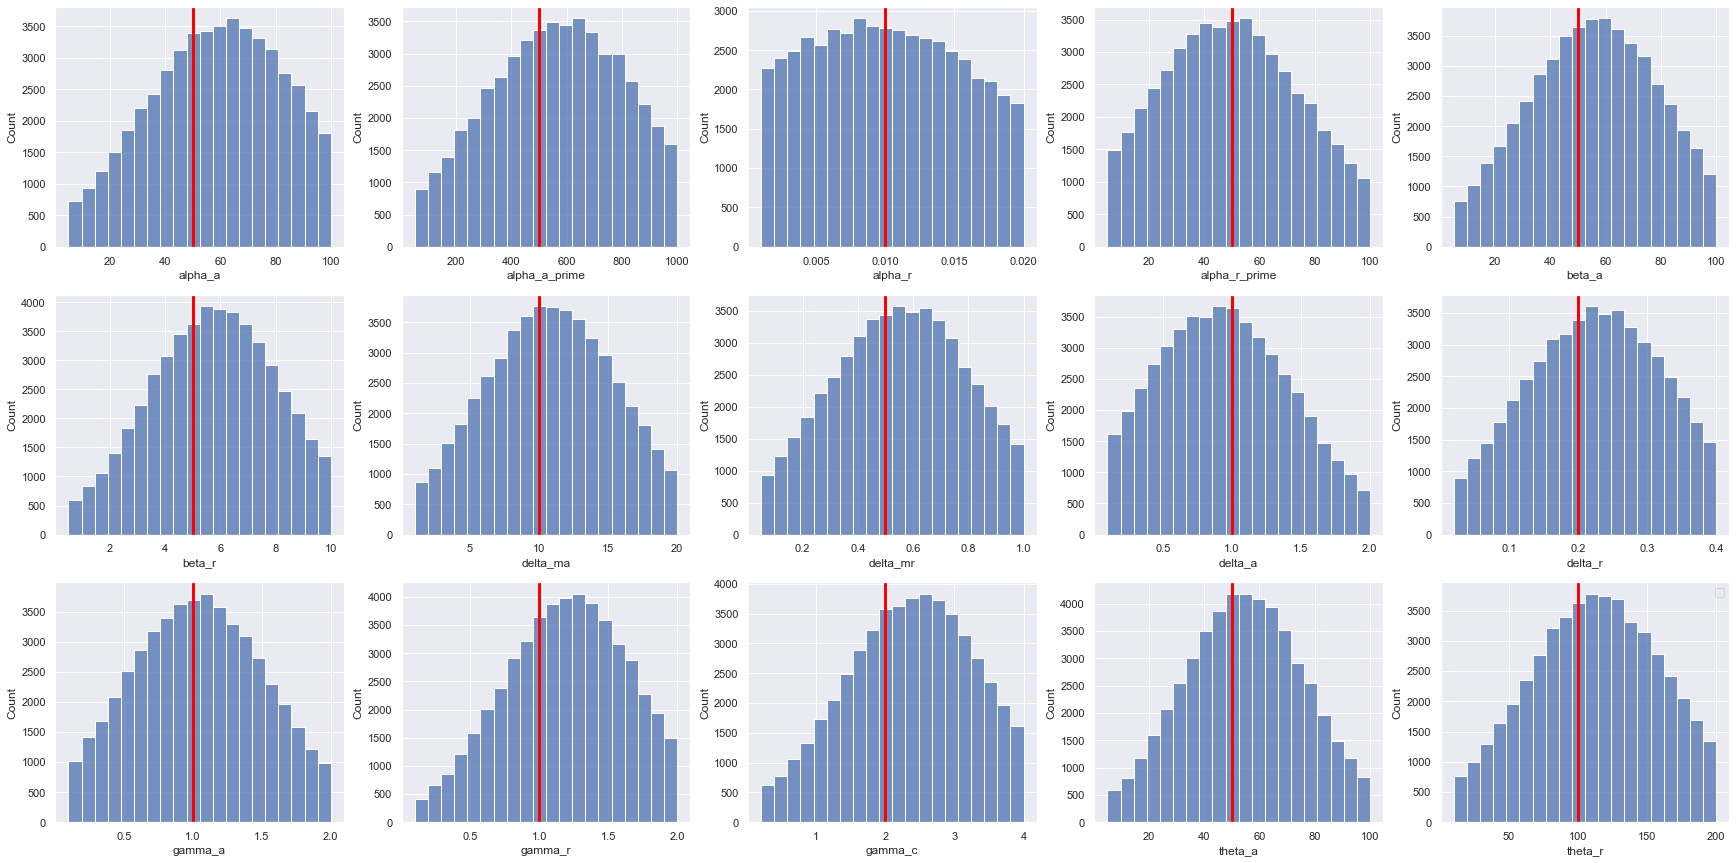

In [47]:
true_params = np.asarray([50.0, 500.0, 0.01, 50.0, 50.0, 5.0, 10.0, 0.5, 1.0, 0.2, 1.0, 1.0, 2.0, 50.0, 100.0])
lower_bounds = true_params * 0.1
upper_bounds = true_params * 2.0
parameter_names = list(vilar_model.listOfParameters.keys())

labels=['alpha_a', 'alpha_a_prime', 'alpha_r', 'alpha_r_prime', 'beta_a', 'beta_r', 'delta_ma',
        'delta_mr', 'delta_a', 'delta_r', 'gamma_a', 'gamma_r', 'gamma_c', 'theta_a', 'theta_r']
sns.set()
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
posterior = np.vstack(samples_cnn.detach().numpy().tolist())
for i in range(15):
    if i < 5:
        a, b = 0, i
    elif 4 < i and i < 10:
        a, b = 1, i-5
    else:
        a, b = 2, i-10

    #axs[a, b].hist(posterior[:,i], bins=30)
    sns.histplot(posterior[:,i], bins=20, ax=axs[a, b])
    axs[a, b].axvline(true_params[i], linewidth=3, color='red')
    axs[a, b].set_xlabel(labels[i])
plt.legend()
plt.show()

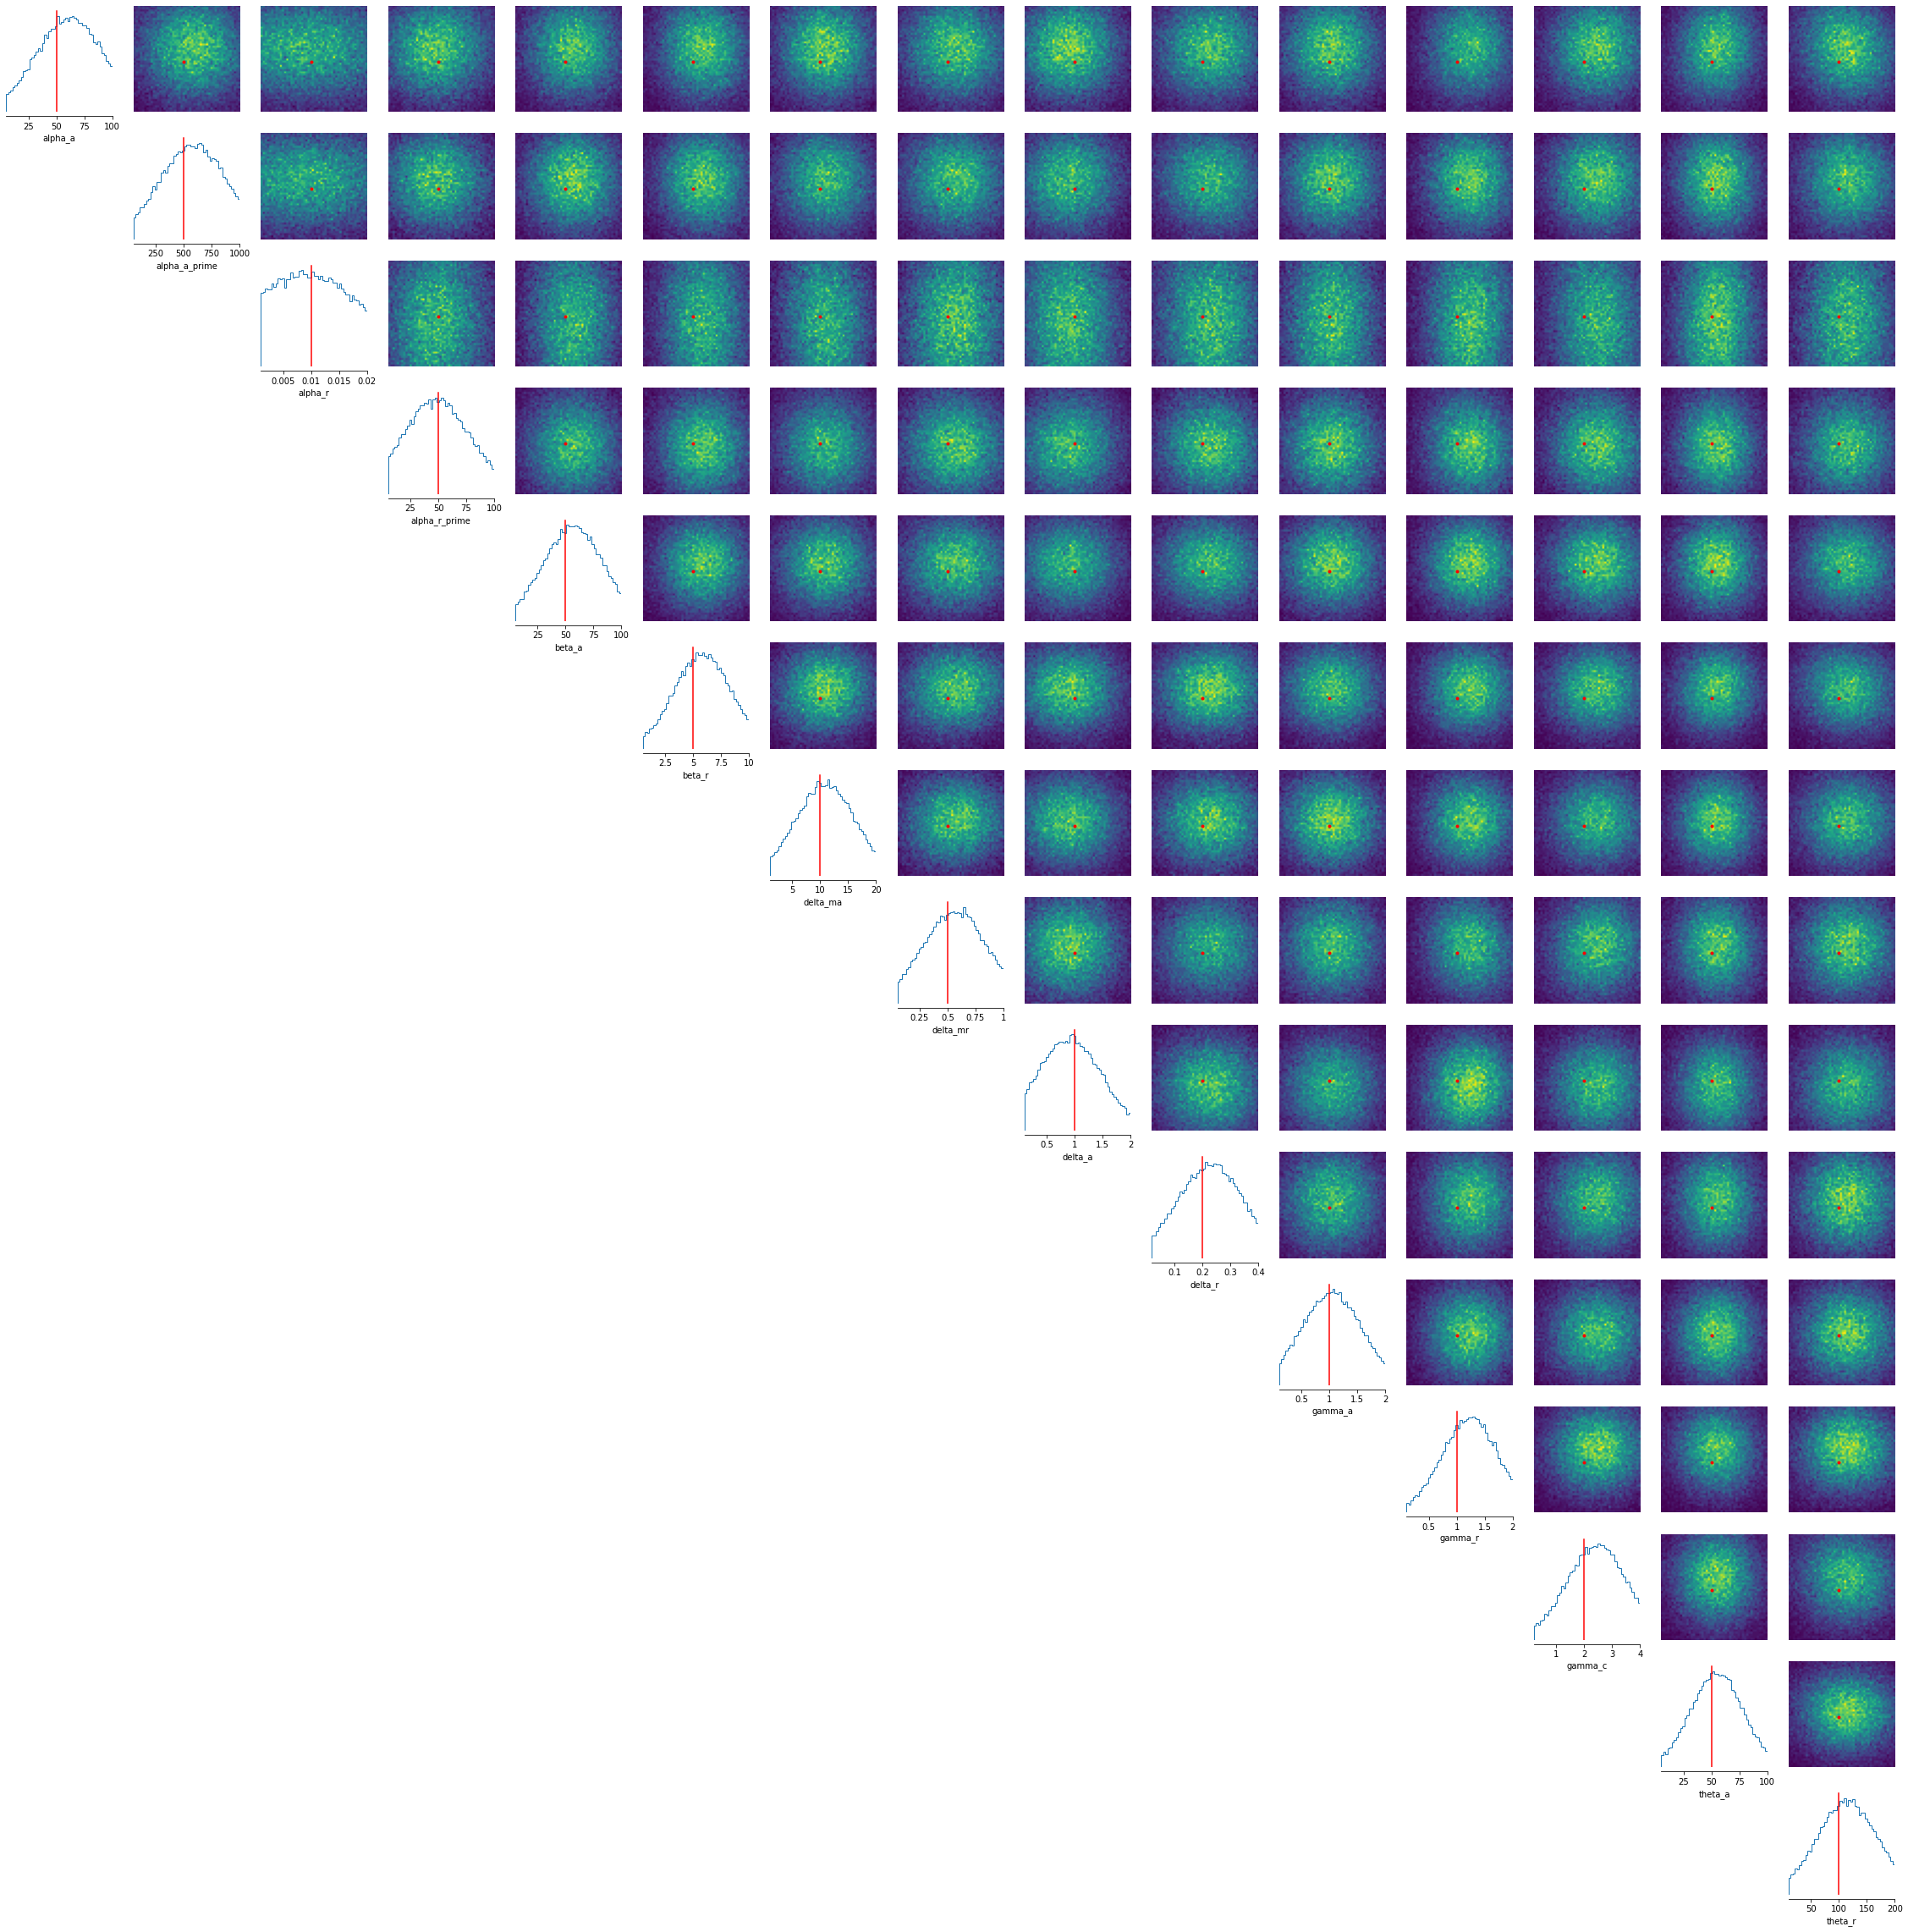

In [30]:
# create the figure
true_param = torch.tensor([50.0, 500.0, 0.01, 50.0, 50.0, 5.0, 10.0, 0.5, 1.0, 0.2, 1.0, 1.0, 2.0, 50.0, 100.0])
result_tuples = zip(dmin, dmax)
result_list = [list(t) for t in result_tuples]

fig, ax = analysis.pairplot(
    samples_cnn,
    points=true_param,
    labels=['alpha_a', 'alpha_a_prime', 'alpha_r', 'alpha_r_prime', 'beta_a', 'beta_r', 'delta_ma',
                    'delta_mr', 'delta_a', 'delta_r', 'gamma_a', 'gamma_r', 'gamma_c', 'theta_a', 'theta_r'],
    limits=result_list,
    points_colors="r",
    points_offdiag={"markersize": 6},
    figsize=(40, 40),
)


## ABC

In [ ]:
import sbi.utils as utils
from sbi.inference.abc.smcabc import SMCABC

sampler = SMCABC(simulator, sbi_prior, distance='mse') 

smc_result = sampler.__call__(obs_stat, num_particles=500, epsilon_decay=0.1, num_initial_pop=500, num_simulations=10000, kde=False, return_summary=False)

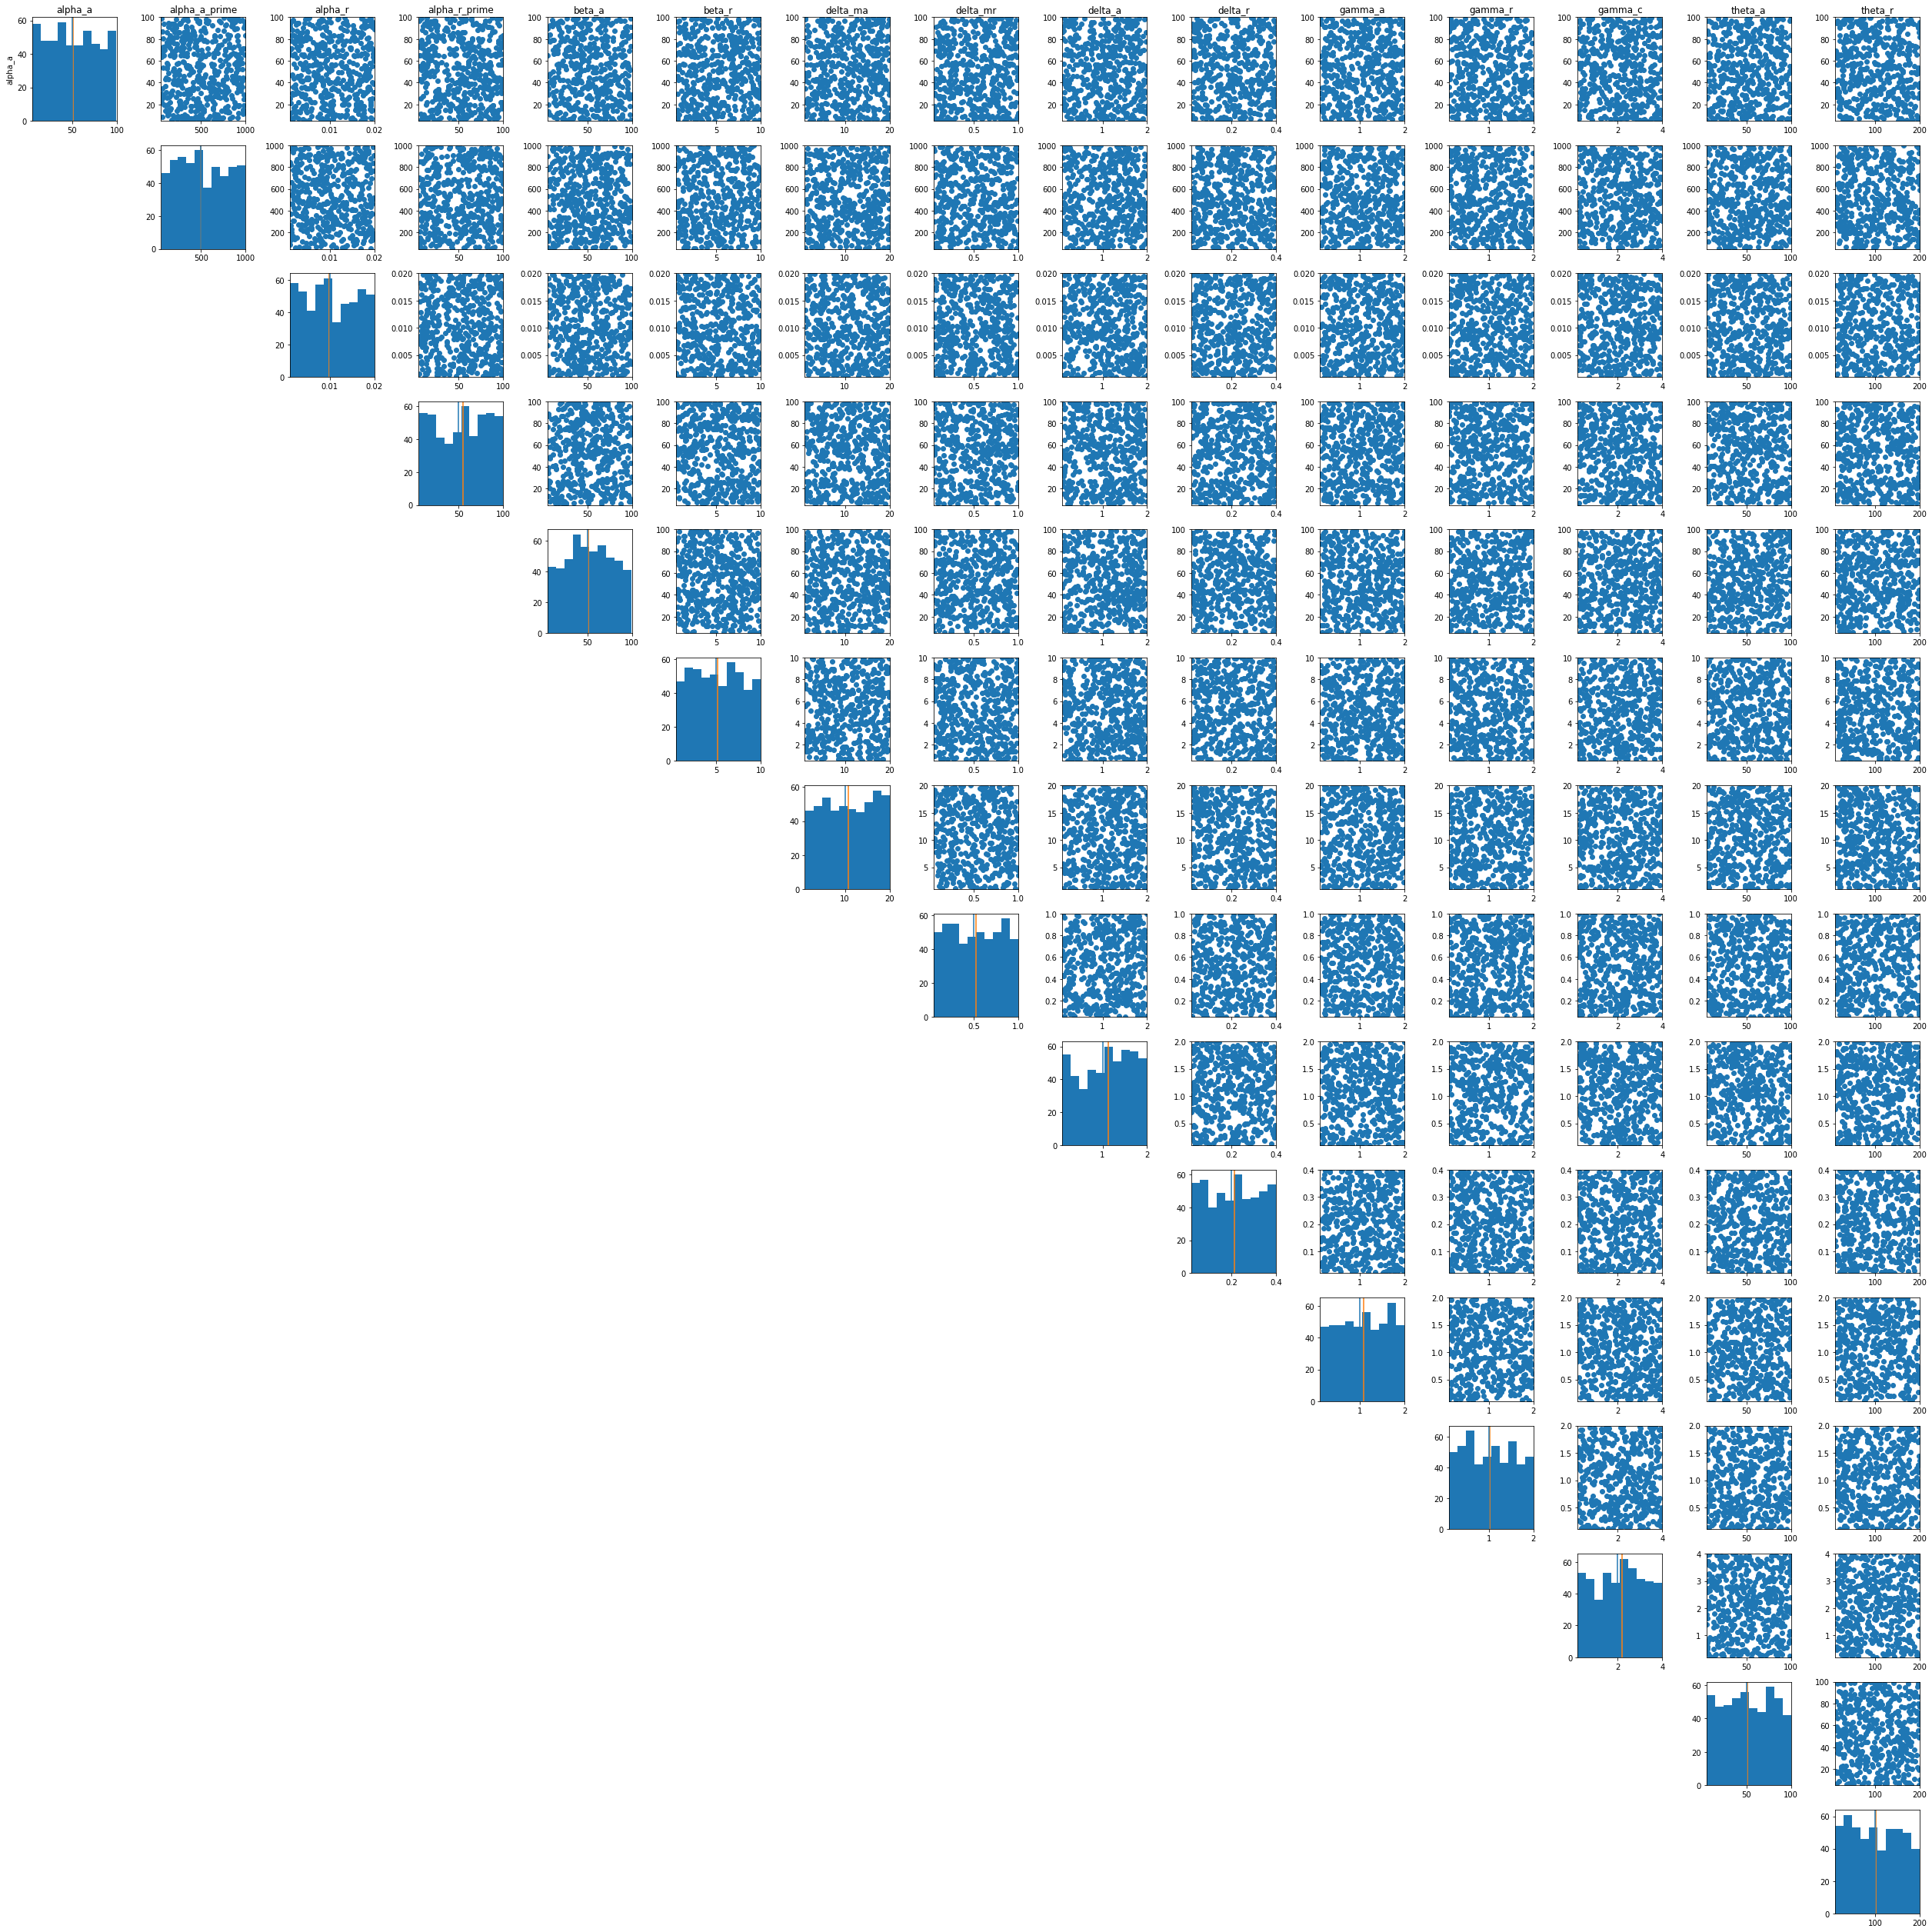

In [64]:
fig, ax = plt.subplots(15, 15, facecolor = 'w')
for i in range(15):
    for j in range(15):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior[:,i], bins = 'auto')
                ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                ax[i,j].axvline(true_params[i])
                ax[i,j].set_xlim(lower_bounds[i], upper_bounds[i])
            else:
                ax[i,j].scatter(posterior[:,j], posterior[:,i])
                ax[i,j].set_ylim(lower_bounds[i], upper_bounds[i])
                ax[i,j].set_xlim(lower_bounds[j], upper_bounds[j])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(35, 35)
fig.tight_layout()

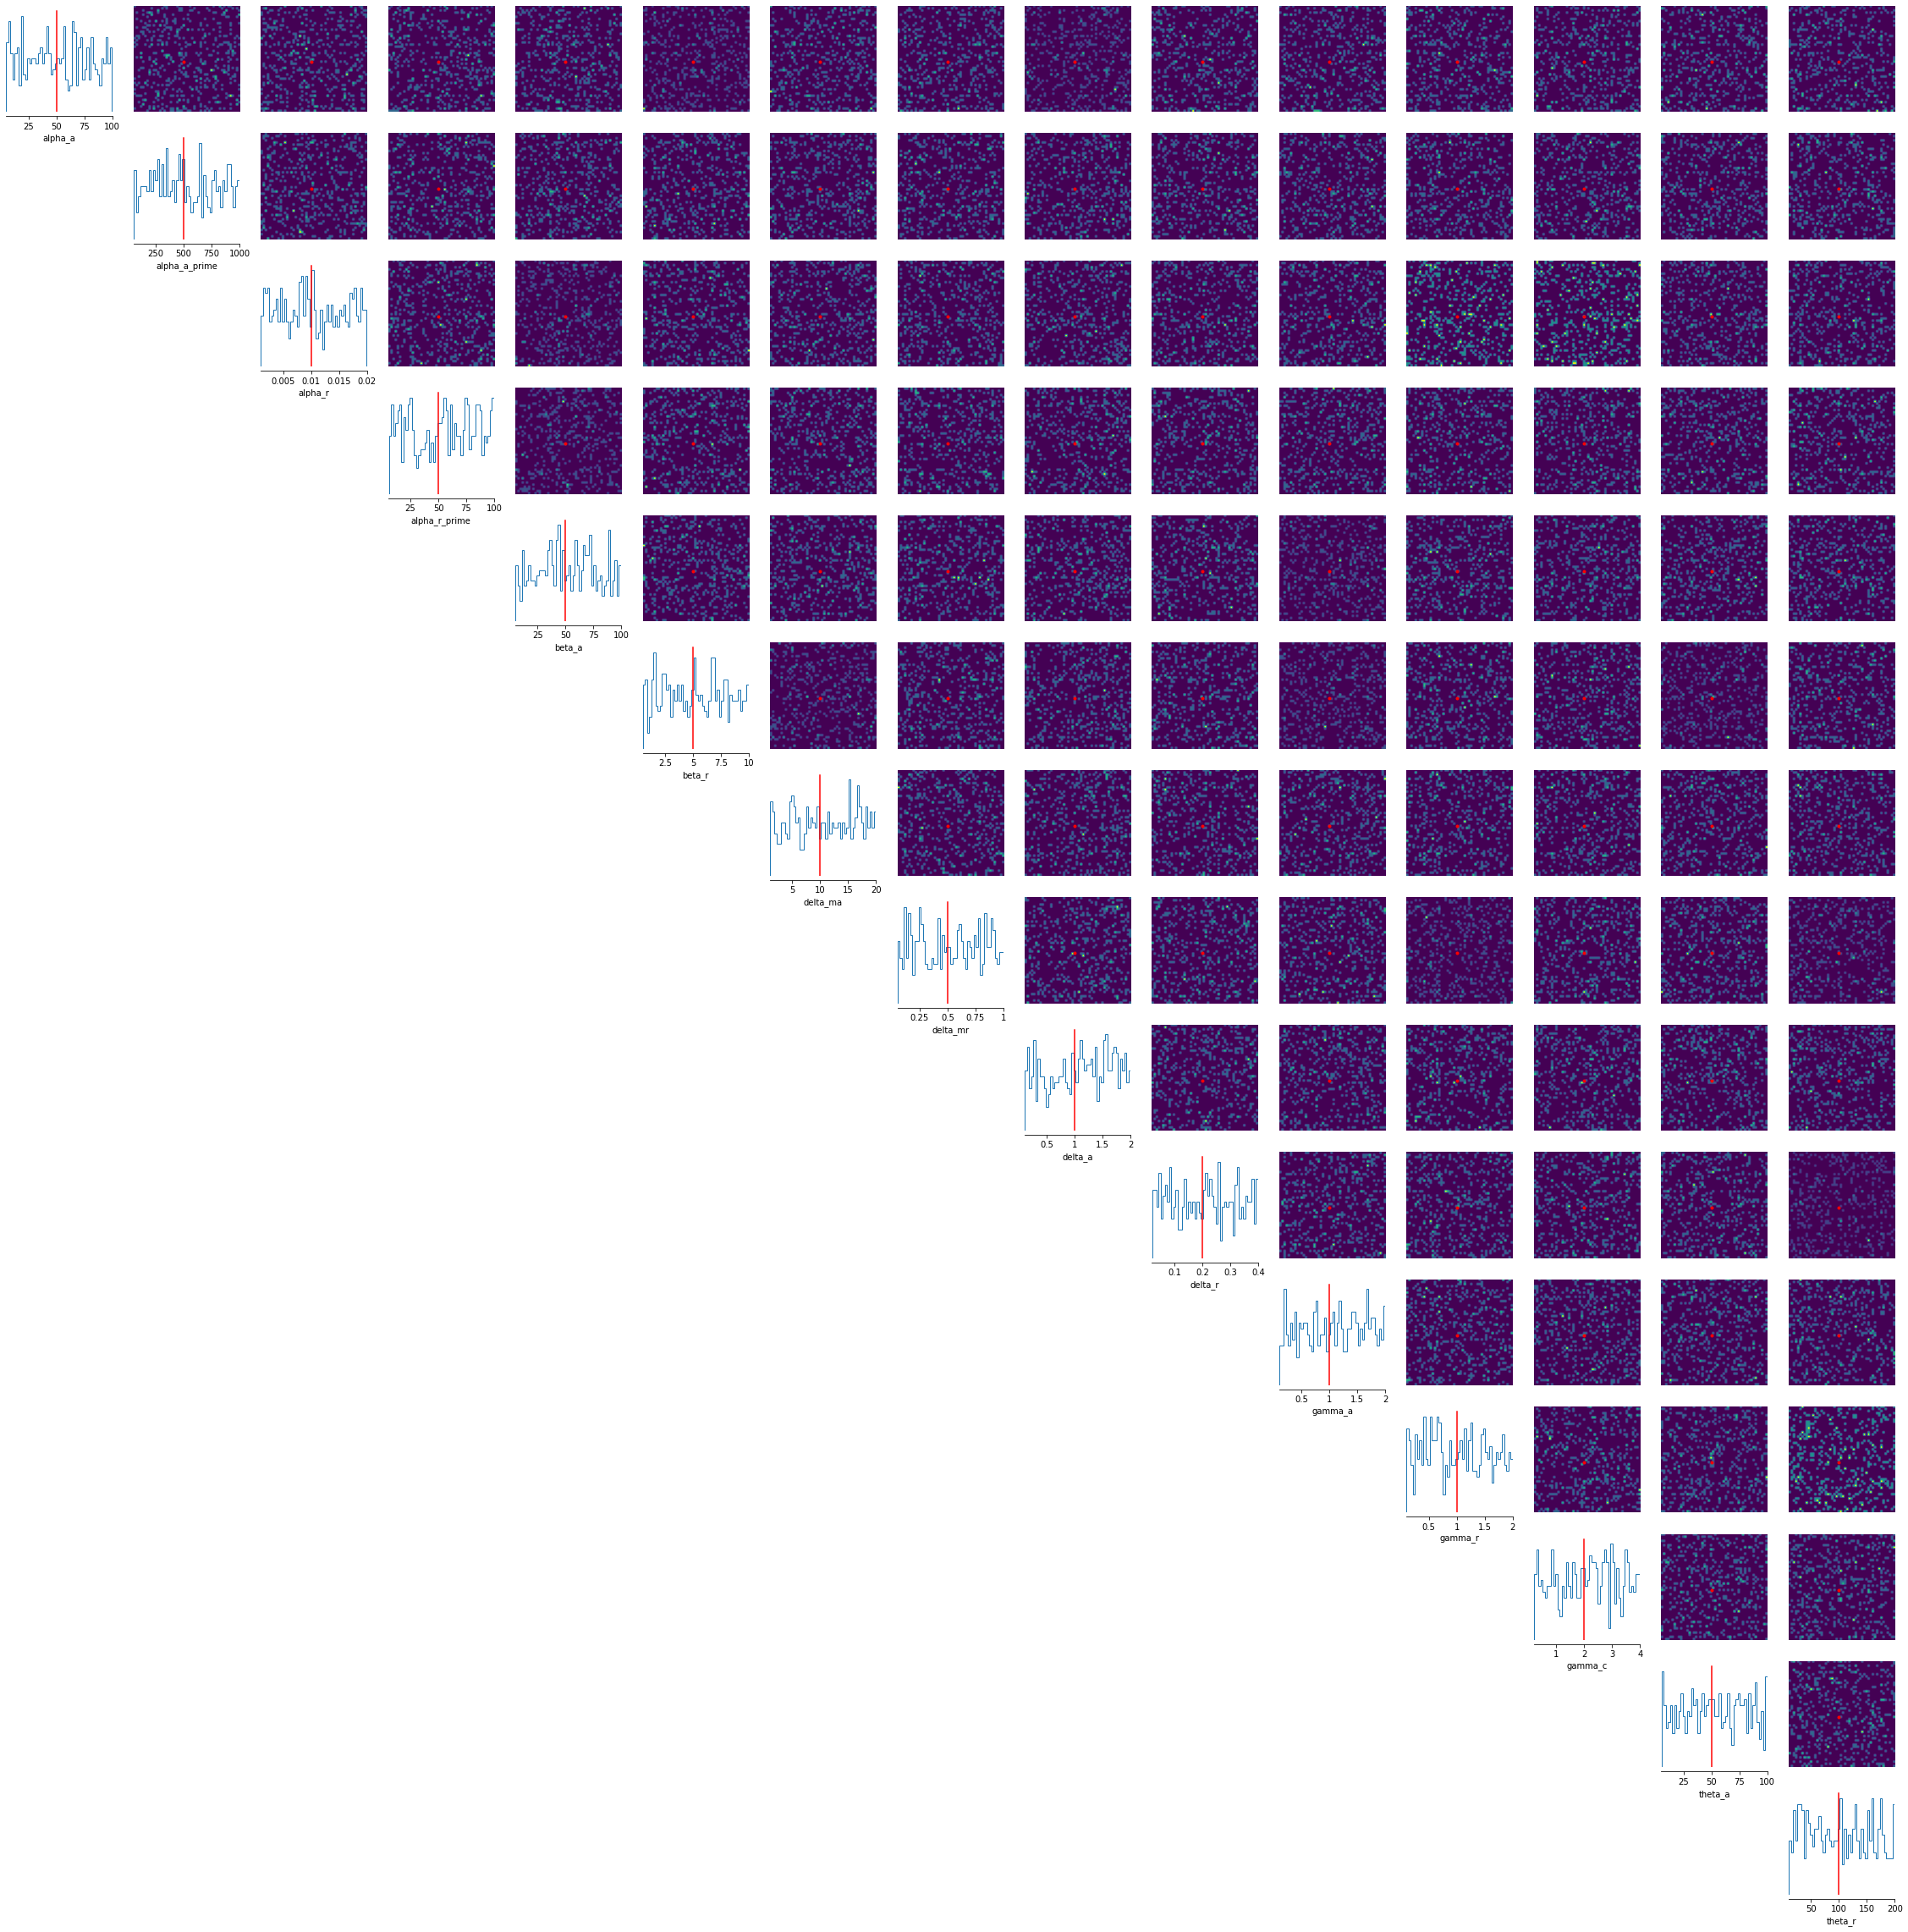

In [65]:
true_param = torch.tensor([50.0, 500.0, 0.01, 50.0, 50.0, 5.0, 10.0, 0.5, 1.0, 0.2, 1.0, 1.0, 2.0, 50.0, 100.0])
result_tuples = zip(dmin, dmax)
result_list = [list(t) for t in result_tuples]

fig, ax = analysis.pairplot(
    smc_result,
    points=true_param,
    labels=['alpha_a', 'alpha_a_prime', 'alpha_r', 'alpha_r_prime', 'beta_a', 'beta_r', 'delta_ma',
                    'delta_mr', 'delta_a', 'delta_r', 'gamma_a', 'gamma_r', 'gamma_c', 'theta_a', 'theta_r'],
    limits=result_list,
    points_colors="r",
    points_offdiag={"markersize": 6},
    figsize=(40, 40),
)